# Cats vs. Dogs using Logistic Regression
In this Jupyter Notebook, we'll implement the theory we learned in https://medium.com/@melodious/understanding-deep-neural-networks-from-first-principles-logistic-regression-bd2f01c9e263 by building a binary classifier that can predict whether an image contains a cat or a dog.

In [3]:
%matplotlib inline
# Import Packages
import os
import sys
import random
import numpy as np
from PIL import Image
from scipy import ndimage
import matplotlib as plt

## Dataset
The data is available at https://www.kaggle.com/c/dogs-vs-cats/data. Make sure you've added the train and test set data into their respective folders in the ./datasets directory.

### Preprocessing
Preprocessing data in order to feed it into the model is often times the most time-consuming part of the machine learning process. In batch_processing() we resize the images to have a consistent width and height of 500 pixels. We then define a method load_data() to convert the images to a numpy array of size (width) x (height) x (# of channels). Since the files are named with either 'Cat' or 'Dog' in the filename, we check for the string and set the label y = 0 for a cat and y = 1 for a dog. We then randomize the files in the directory so that all the cats and dogs aren't lumped together.

In [4]:
def batch_preprocessing():
    width = 500
    height = 500
    train_dir = 'datasets/train/'
    test_dir = 'datasets/test/'

    # Pre-process training set
    for image in os.listdir(train_dir):
        print('Resizing image ' + image)
        img = Image.open(os.path.join(train_dir,image))
        img = img.resize((width,height), Image.BILINEAR)
        img.save(os.path.join(train_dir,image))
    print('Batch pre-processing on {} files in training set complete'.format(len(os.listdir(train_dir))))
    print('///////////////')
    # Pre-process test set
    for image in os.listdir(test_dir):
        print('Resizing image ' + image)
        img = Image.open(os.path.join(test_dir,image))
        img = img.resize((width,height), Image.BILINEAR)
        img.save(os.path.join(test_dir,image))
    print('Batch pre-processing on {} files in test set complete'.format(len(os.listdir(test_dir))))

In [5]:
def load_data():
    
    train_dir = 'datasets/train/'
    test_dir = 'datasets/test/'
    
    # initialize arrays
    files_train = len(os.listdir(train_dir))
    files_test = len(os.listdir(test_dir))
    train_set_x = np.random.randint(0,255,size=(files_train,500,500,3),dtype='uint8')
    train_set_y = np.zeros((1,files_train))
    test_set_x = np.random.randint(0,255,size=(files_test,500,500,3),dtype='uint8')
    test_set_y = np.zeros((1,files_test))

    # load training files
    for i,image in zip(range(files_train),os.listdir(train_dir)):   
        train_set_x[i] = np.array(Image.open(os.path.join(train_dir,image)))
        # create training set labels (0: cat, 1: dog)
        if 'dog' in str(os.path.join(train_dir,image)):
            train_set_y[:,i] = 1
            
    # load test files 
    for i,image in zip(range(files_test),os.listdir(test_dir)):   
        test_set_x[i] = np.array(Image.open(os.path.join(test_dir,image)))
        # create test set labels (0: cat, 1: dog)
        if 'dog' in str(os.path.join(test_dir,image)):
            test_set_y[:,i] = 1
    
    # randomize files 
    idx_train = np.random.permutation(files_train)
    idx_test = np.random.permutation(files_test)
    train_set_x, train_set_y = train_set_x[idx_train,:], train_set_y[:,idx_train]
    test_set_x, test_set_y = test_set_x[idx_test,:], test_set_y[:,idx_test]
    
    # make sure arrays are correctly shaped
    assert(train_set_x.shape == (files_train,500,500,3))
    assert(train_set_y.shape == (1,files_train))
    assert(test_set_x.shape == (files_test,500,500,3))
    assert(test_set_y.shape == (1,files_test))
    
    return train_set_x,train_set_y,test_set_x,test_set_y

### Visualize and split data
After loading the data, it's helpful to visualize it.
We also split the training data and keep 80% as the training set and 20% as the validation set. This way, we can train and check our results without contaminating and overfitting to our test set.

8


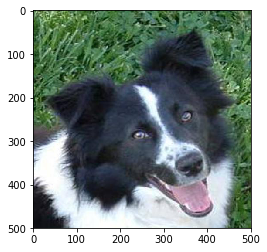

In [6]:
train_set_x,train_set_y,test_set_x,test_set_y = load_data()

# Visualize an example
plt.pyplot.imshow(train_set_x[4])

# Split 80% of training set data, use other 20% as validation set
cut_off = int(train_set_x.shape[0]*0.8)
val = train_set_x.shape[0]-cut_off
print(cut_off)
train_set_x_split = train_set_x[0:cut_off]
train_set_y_split = train_set_y[0,0:cut_off].reshape(1,cut_off)
validation_set_x = train_set_x[cut_off:]
validation_set_y = train_set_y[0,cut_off:].reshape(1,val)


In [7]:
# Define number of training, validation, and test examples and image dimensions  
m_train = train_set_x.shape[0]
m_val = validation_set_x.shape[0]
m_test = test_set_x.shape[0]
num_px = train_set_x.shape[1]

# Flatten images into vectors
train_set_x_flatten = train_set_x_split.reshape(train_set_x_split.shape[0],-1).T
validation_set_x_flatten = np.reshape(validation_set_x,(num_px*num_px*3,m_val))
test_set_x_flatten = np.reshape(test_set_x,(num_px*num_px*3,m_test))
print(train_set_x_flatten.shape,validation_set_x_flatten.shape, test_set_x_flatten.shape)

# Standardize images by dividing by max value of a pixel channel (255)
train_set_x_standardized = train_set_x_flatten/255.
validation_set_x_standardized = validation_set_x_flatten/255.
test_set_x_standardized = test_set_x_flatten/255.

((750000, 8), (750000, 2), (750000, 5))


In [8]:
# Print out all the shapes
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of validation examples: m_val = " + str(m_val))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("\\\\\\\\\\\\\\\\")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_x_split shape: " + str(train_set_x_split.shape))
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_x_standardized shape: " + str(train_set_x_standardized.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("train_set_y_split shape: " + str(train_set_y_split.shape))
print("\\\\\\\\\\\\\\\\")
print ("validation_set_x shape: " + str(validation_set_x.shape))
print ("validation_set_x_flatten shape: " + str(validation_set_x_flatten.shape))
print ("validation_set_x_standardized shape: " + str(validation_set_x_standardized.shape))
print ("validation_set_y shape: " + str(validation_set_y.shape))
print("\\\\\\\\\\\\\\\\")
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_x_standardized shape: " + str(test_set_x_standardized.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


Number of training examples: m_train = 10
Number of validation examples: m_val = 2
Number of testing examples: m_test = 5
Height/Width of each image: num_px = 500
Each image is of size: (500, 500, 3)
\\\\\\\\
train_set_x shape: (10, 500, 500, 3)
train_set_x_split shape: (8, 500, 500, 3)
train_set_x_flatten shape: (750000, 8)
train_set_x_standardized shape: (750000, 8)
train_set_y shape: (1, 10)
train_set_y_split shape: (1, 8)
\\\\\\\\
validation_set_x shape: (2, 500, 500, 3)
validation_set_x_flatten shape: (750000, 2)
validation_set_x_standardized shape: (750000, 2)
validation_set_y shape: (1, 2)
\\\\\\\\
test_set_x shape: (5, 500, 500, 3)
test_set_x_flatten shape: (750000, 5)
test_set_x_standardized shape: (750000, 5)
test_set_y shape: (1, 5)


## Logistic Regression Model

We are finally ready to implement the model. We'll do so in steps. First we define the sigmoid function. Then we implement forward and backward propagation. Note that we compute and store the gradients dw and db for future use

In [9]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [10]:
def propagate(w,b,X,Y):
    m = X.shape[1]
    # forward prop
    A = sigmoid(np.dot(np.transpose(w),X)+b)
    cost = (-1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    # back prop
    dw = (1/m)*np.dot(X,np.transpose(A-Y))
    db = (1/m)*np.sum(A-Y)

    cost = np.squeeze(cost)

    grads = {"dw": dw,
            "db": db}
    
    return grads,cost

In [11]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 25 == 0:
            costs.append(cost)
        
        if print_cost and i % 25 == 0:
            print("Cost after iteration i: {}".format(i,cost))
        
    params = {"w": w,
              "b": b}
        
    grads = {"dw": dw,
             "db": db}
        
    return params, grads, costs

In [12]:
def predict(w,b,X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        Y_prediction[np.where(A>0.5)] = 1
    
    return Y_prediction
    
    

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.4, print_cost=False):
    
    w = np.zeros((X_train.shape[0],1))
    b = np.zeros(1)
    parameters, grads, costs = optimize(w,b,X_train,Y_train, num_iterations, learning_rate)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    
    print("Training set accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_train-Y_train) * 100)))
    print("Test set accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    model_out = {"costs": costs,
                     "Y_prediction_test": Y_prediction_test,
                     "Y_prediction_train": Y_prediction_train,
                     "w": w,
                     "b": b,
                     "learning_rate": learning_rate,
                     "num_iterations": num_iterations}
    return model_out

In [16]:
model_out = model(train_set_x_flatten, train_set_y_split, test_set_x_standardized, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Training set accuracy: 62.5%
Test set accuracy: 40.0%


In [250]:
model_out["Y_prediction_train"]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Next steps
How does varying learning rate, doing further feature engineering on the input images, and adding regularization affect the accuracy of the model?


References:

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c